In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast/uncertainty


In [2]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, BatchNormalization, Lambda, 
                                     concatenate, Embedding, Reshape)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

import wandb
from wandb.keras import WandbCallback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import BatchCreator, Logger, plot_confidence_series, plot_some_confidence_intervals
from model_builder import (get_pinball_losses, get_simple_dist_model, get_simple_dense_model,
                           get_variable_dist_model, get_direct_dist_model)
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model
from preprocess import preprocess, get_features, pandas_cat_data, reset_categorical_features


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
plt.rcParams['font.size'] = 13

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Prediction delay - level 10

In [4]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [5]:
level = 10

model_dir = 'models/uncertainty/delay_opt/level_{}/'.format(level)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Read data

In [6]:
prediction_lag = 7

In [7]:
fn = data_dir + 'prep/level_{}_simple_fe_2011_01_29_2016_04_24_normalised_demand_lag_{}.pickle'.format(
    level, prediction_lag)

# check if already preprocessed
if os.path.exists(fn):
    data = pd.read_pickle(fn)
else:
    # choose number of years to include
    n_years = 6  # all
    
    # preform preprocessing
    data = preprocess(level=level, n_years=n_years, DAYS_PRED=prediction_lag, 
                      save_prepared_dataset=True, data_dir=data_dir)
    
# set categorical features
data, available_cat_features = pandas_cat_data(data)

# reset categorical features, set NaN events as additional category, set NaN shift/std/mean/kurt/skew to zero
data = reset_categorical_features(data, available_cat_features)

# select features
features = get_features(level=level, prediction_lag=prediction_lag, 
                        sell_price_features=('sell_price' in data.columns))
print(features)

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Mem. usage decreased to 11.22 Mb (74.8% reduction)
3049 7
Mem. usage decreased to  0.08 Mb (36.9% reduction)
Mem. usage decreased to 11.16 Mb (0.5% reduction)
Mem. usage decreased to 45.67 Mb (65.0% reduction)
Melted sales train validation has 5832737 rows and 6 columns
Selecting 6677310 rows (114.5%)
Mem. usage decreased to 483.94 Mb (0.0% reduction)
Saving to file..
Finished.
['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'shift_t7', 'shift_t8', 'shift_t9', 'rolling_std_t7', 'rolling_std_t30', 'rolling_std_t60', 'rolling_std_t90', 'rolling_std_t180', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180', 'rolling_skew_t30', 'rolling_kurt_

In [8]:
data.filter(regex='shift').head()

,shift_t7,shift_t8,shift_t9
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


## Setup training

In [9]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [10]:
def get_generators(batch_size=1024):
    labels = ['demand']
    train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                      batch_size=batch_size, check_nan=False)
    val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                     categorical_features=available_cat_features, batch_size=batch_size,
                                     check_nan=False)
    
    return train_batch_creator, val_batch_creator

# setup for training
train_batch_creator, val_batch_creator = get_generators()

# determine model input shape
x, y = next(train_batch_creator.flow())
INP_SHAPE = x[0].shape

# make losses
losses = get_pinball_losses()

# lazy evaluation of model
def lazy_evaluate_model(model):
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    return metrics, df

## Train with lag of 7 days

In [12]:
# set batch size
train_batch_creator, val_batch_creator = get_generators()

# setup metric tracking
logger = Logger(val_batch_creator)

# build model
model = get_direct_dist_model(inp_shape=INP_SHAPE, num_nodes=256)
model.compile(optimizer=Adam(1e-5), loss=losses)

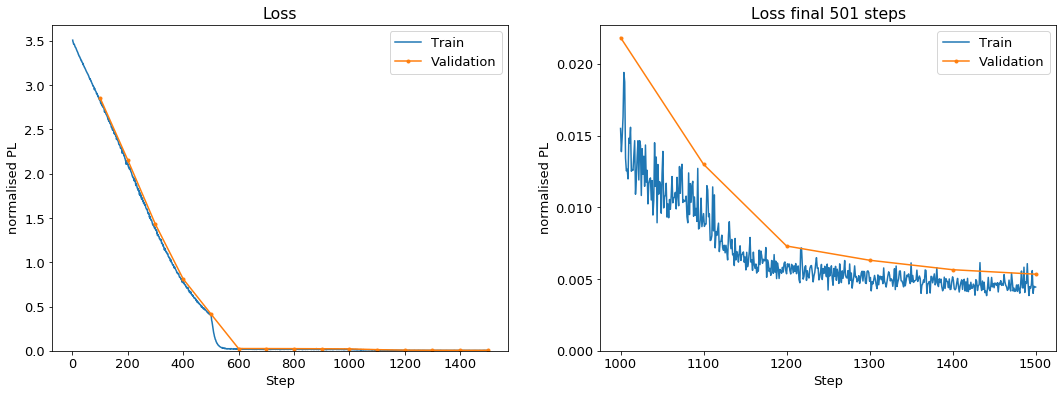

100/100 [==============================] - 47s 470ms/step - loss: 0.0046 - q0_loss: 3.5829e-05 - q1_loss: 1.2472e-04 - q2_loss: 6.2822e-04 - q3_loss: 7.7839e-04 - q4_loss: 0.0010 - q5_loss: 8.7187e-04 - q6_loss: 7.4393e-04 - q7_loss: 2.6153e-04 - q8_loss: 8.9407e-05 - val_loss: 0.0053 - val_q0_loss: 3.7709e-05 - val_q1_loss: 1.5912e-04 - val_q2_loss: 7.7581e-04 - val_q3_loss: 8.4095e-04 - val_q4_loss: 0.0011 - val_q5_loss: 0.0010 - val_q6_loss: 9.1142e-04 - val_q7_loss: 3.3343e-04 - val_q8_loss: 9.8158e-05


In [13]:
lr_list = [1e-5, 1e-4, 1e-3]

for lr_block in lr_list:
    # set lr (without recompiling and losing momentum)
    def lr_scheduler(epoch, lr):
        return lr_block
    lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
    
    # train model
    history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                        validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                        callbacks=[lr_callback, logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.25590089525671667, 'WSPL': 0.25590089525671667}


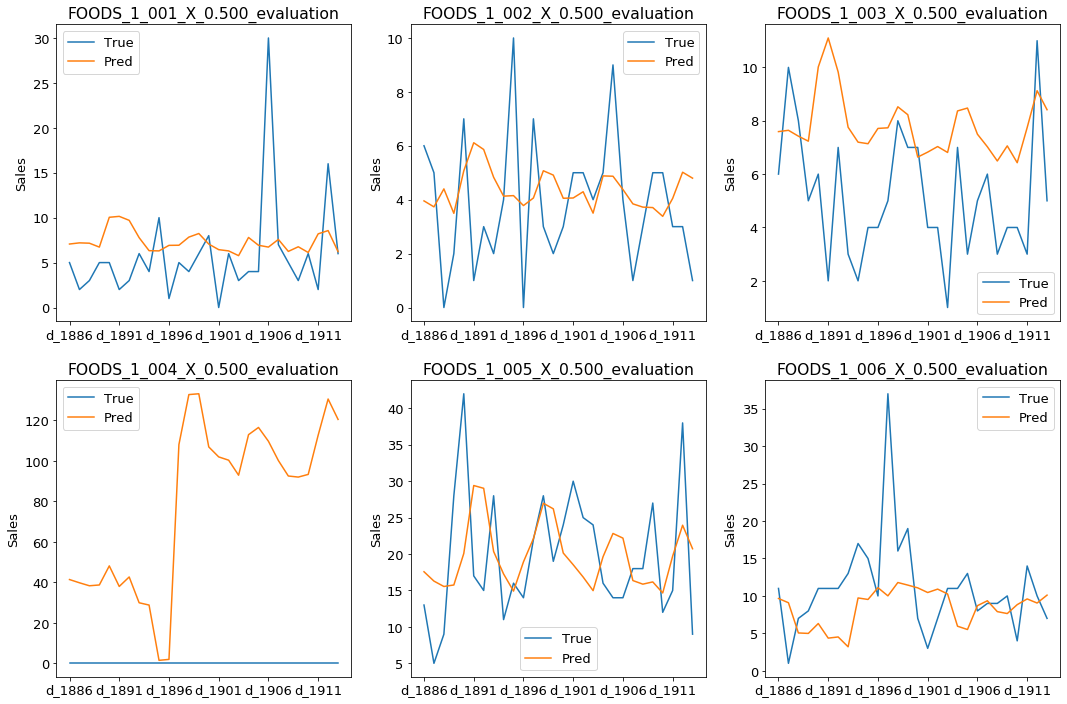

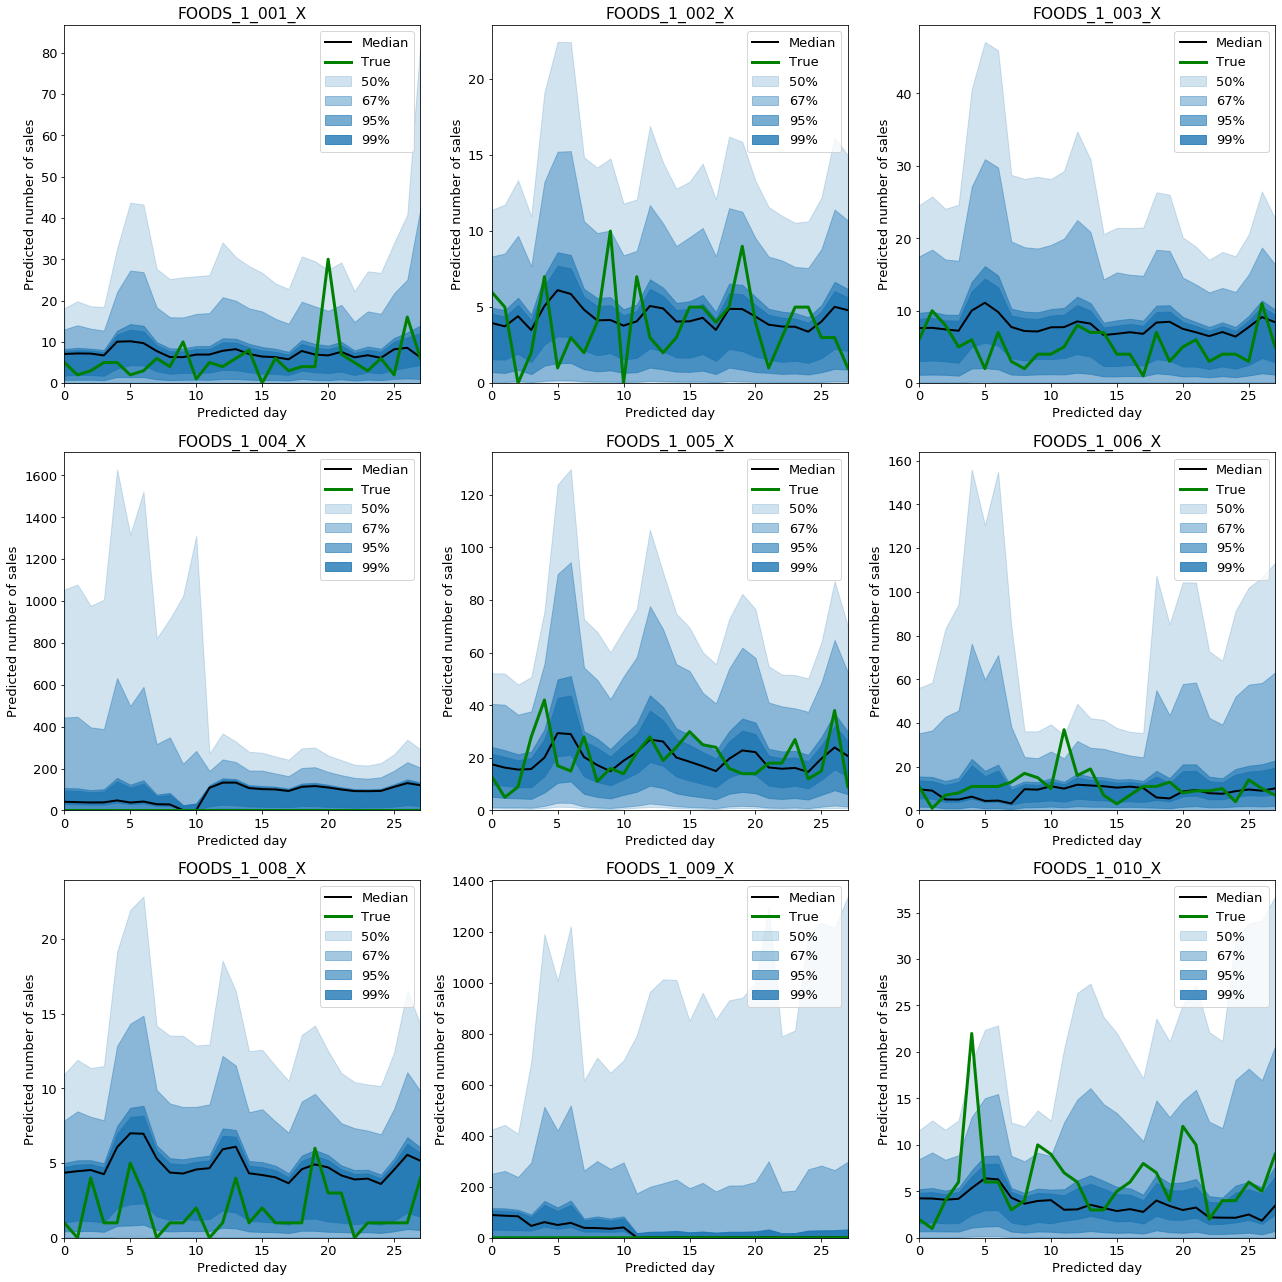

In [14]:
# save trained model
model.save_weights(model_dir + 'direct256_lag7.h5')

# evaluate
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
plot_some_confidence_intervals(df, val_batch_creator, level, quantiles, data_dir)

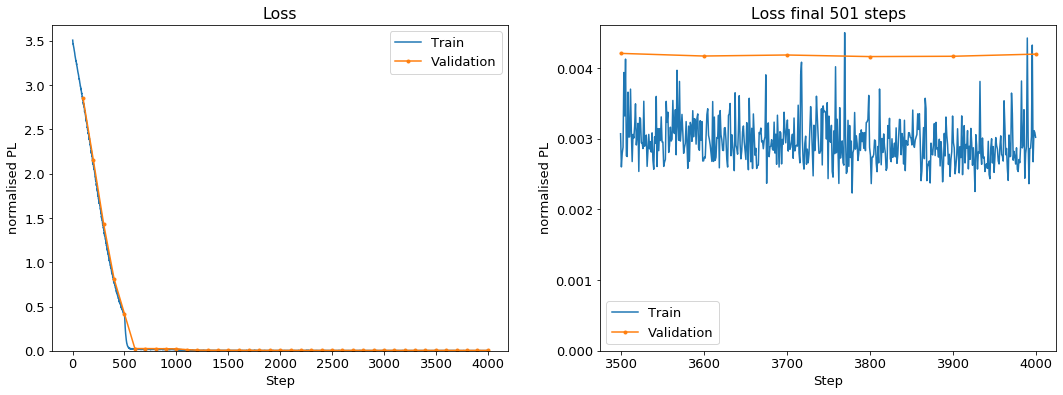

100/100 [==============================] - 46s 464ms/step - loss: 0.0029 - q0_loss: 2.3500e-05 - q1_loss: 1.0994e-04 - q2_loss: 3.8699e-04 - q3_loss: 4.9097e-04 - q4_loss: 6.4277e-04 - q5_loss: 5.4767e-04 - q6_loss: 4.5419e-04 - q7_loss: 1.5179e-04 - q8_loss: 6.3020e-05 - val_loss: 0.0042 - val_q0_loss: 3.5833e-05 - val_q1_loss: 1.6412e-04 - val_q2_loss: 5.6492e-04 - val_q3_loss: 7.3160e-04 - val_q4_loss: 9.4230e-04 - val_q5_loss: 8.2264e-04 - val_q6_loss: 6.7926e-04 - val_q7_loss: 2.0257e-04 - val_q8_loss: 5.5088e-05


In [15]:
lr_list = [2e-3, 3e-3, 1e-3, 3e-4, 1e-4]

for lr_block in lr_list:
    # set lr (without recompiling and losing momentum)
    def lr_scheduler(epoch, lr):
        return lr_block
    lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
    
    # train model
    history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                        validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                        callbacks=[lr_callback, logger])

In [21]:
# save trained model
model.save_weights(model_dir + 'direct256_lag7_step2.h5')

In [17]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level, verbose=False)
print(metrics)

Predicting...
Denormalising...
Warping predictions...
{10: 0.2015452570982577, 'WSPL': 0.2015452570982577}


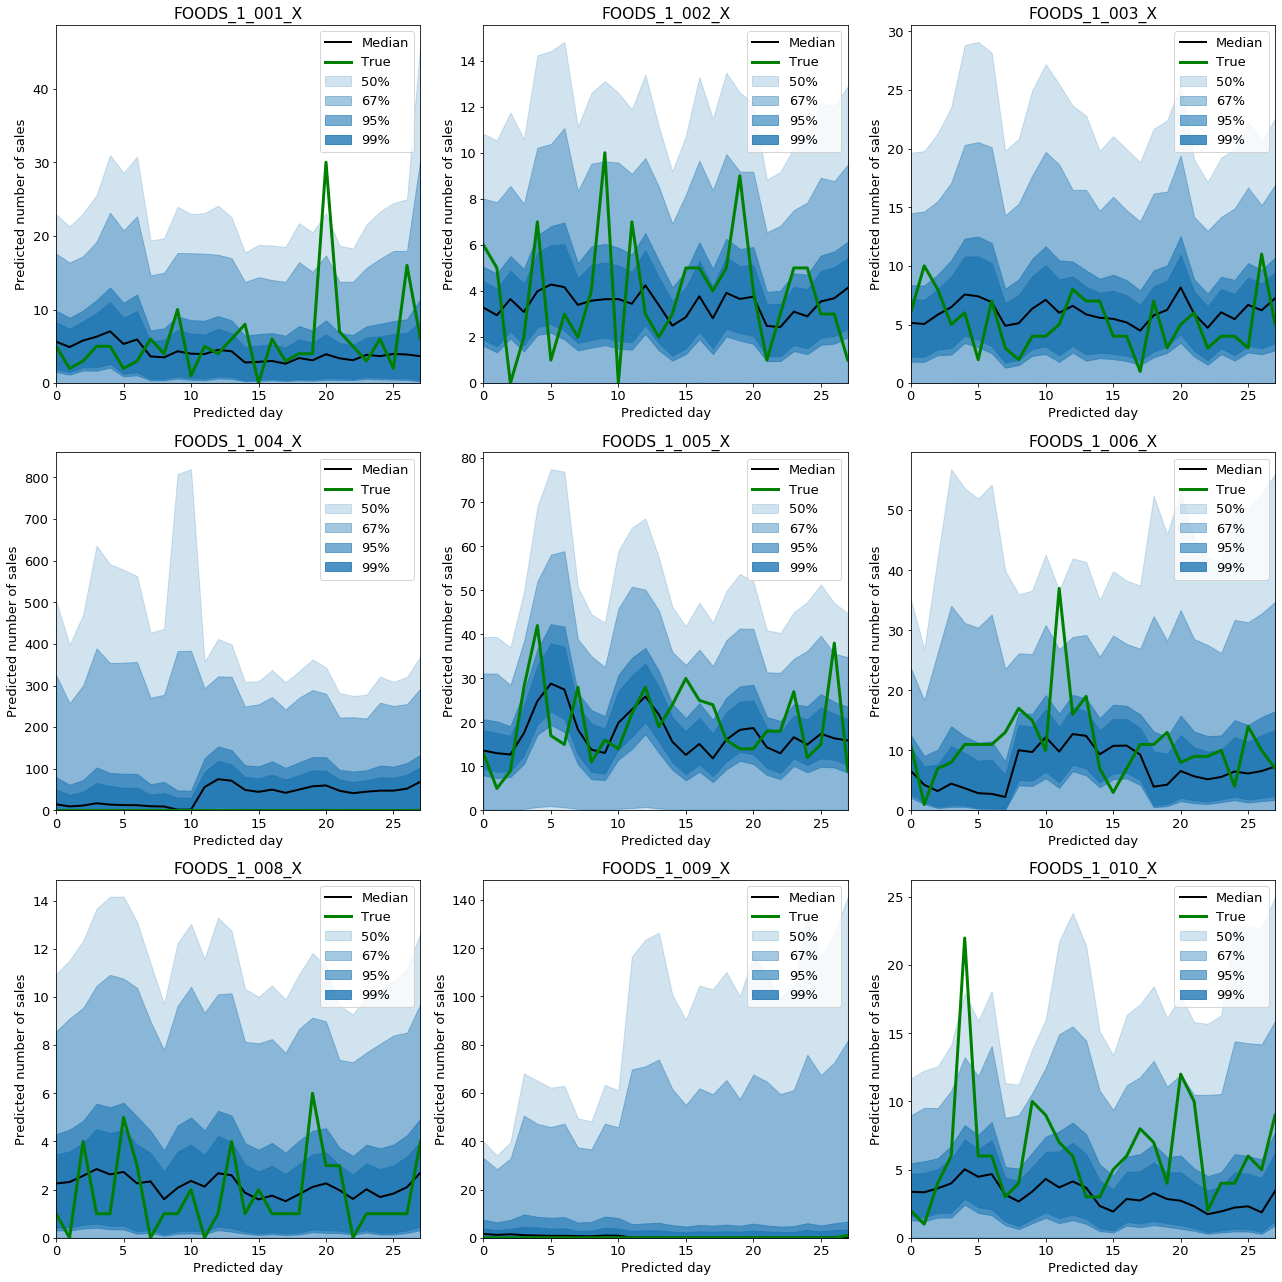

In [27]:
plot_some_confidence_intervals(df, val_batch_creator, level, quantiles)